# This repo contains the following:
- Code for CNN-based classification for MNIST Dataset
- Code for Pointnet classification for MNIST3d Dataset
- Code for Fusion-based classification for MNIST and MNIST3D Dataset

In [1]:
# Import libraries
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt
import h5py
import pandas as pd

tf.random.set_seed(1234)


2022-12-02 00:41:31.871631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 00:41:32.639468: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-02 00:41:32.639531: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-02 00:41:32.639538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)

### Load MNIST Dataset

In [3]:
DATADIR = '../data/multimodal/mnist3d/'

In [4]:
# with h5py.File(DATADIR + 'full_dataset_vectors.h5', 'r') as dataset:
#     X_train = dataset['X_train'][:]
#     X_test = dataset['X_test'][:]
#     y_train = dataset['y_train'][:]
#     y_test = dataset['y_test'][:]

In [5]:
noOfpoints = 2048
BATCH_SIZE = 32
run_type = 'demo'
run_type = 'full'

NUM_CLASSES = 10
num_classes = NUM_CLASSES
NUM_POINTS = noOfpoints

In [6]:
with h5py.File(DATADIR + 'train_point_clouds.h5', 'r') as points_dataset:

    # Array to store data...
    x_train_2d = []
    x_train_3d = []
    y_train = [] 

    # Looping over the whole dataset..
    for i, (key, sample) in enumerate(points_dataset.items()):
        
        # Saving images...
        x_train_2d.append(sample['img'][:])

        # Sampling point cloud and saving...
        pointCloud = sample['points'][:]
        num_of_rows = pointCloud.shape[0]
        random_ind = np.random.choice(num_of_rows, size=noOfpoints, replace=False)
        pointCloud = pointCloud[random_ind, :]
        x_train_3d.append(pointCloud)

        # Ssaving labels...
        y_train.append(sample.attrs['label'])

# converting to np array...
x_train_2d = np.stack(x_train_2d)
x_train_3d = np.stack(x_train_3d)
y_train = np.array(y_train)

In [7]:
with h5py.File(DATADIR + 'test_point_clouds.h5', 'r') as points_dataset:

    # Array to store data...
    x_test_2d = []
    x_test_3d = []
    y_test = [] 

    # Looping over the whole dataset..
    for i, (key, sample) in enumerate(points_dataset.items()):
        
        # Saving images...
        x_test_2d.append(sample['img'][:])

        # Sampling point cloud and saving...
        pointCloud = sample['points'][:]
        num_of_rows = pointCloud.shape[0]
        random_ind = np.random.choice(num_of_rows, size=noOfpoints, replace=False)
        pointCloud = pointCloud[random_ind, :]
        x_test_3d.append(pointCloud)

        # Ssaving labels...
        y_test.append(sample.attrs['label'])

# converting to np array...
x_test_2d = np.stack(x_test_2d)
x_test_3d = np.stack(x_test_3d)
y_test = np.array(y_test)

In [8]:
# Creating dataset for mnist 3D data...

In [9]:
# adding extra...

total_training_samples = x_train_3d.shape[0]
total_testing_samples = x_test_3d.shape[0]

random_trainig_indices = np.arange(total_training_samples)
np.random.shuffle(random_trainig_indices)

random_testing_indices = np.arange(total_testing_samples)
np.random.shuffle(random_testing_indices)


print(f"No of training samples: {x_train_3d.shape[0]}")
print(f"No of testing samples: {x_test_3d.shape[0]}")


if run_type == 'demo':
    demo_training_samples = 100
    demo_testing_samples = 100

    random_trainig_indices = random_trainig_indices[0:demo_training_samples]
    random_testing_indices = random_testing_indices[0:demo_testing_samples]

x_train_2d_sel = x_train_2d[random_trainig_indices]
x_train_3d_sel = x_train_3d[random_trainig_indices]
y_train_sel = y_train[random_trainig_indices]

x_test_2d_sel = x_test_2d[random_testing_indices]
x_test_3d_sel = x_test_3d[random_testing_indices]
y_test_sel = y_test[random_testing_indices]


# convert class vectors to binary class matrices
y_train_sel_b = keras.utils.to_categorical(y_train_sel, num_classes)
y_test_sel_b = keras.utils.to_categorical(y_test_sel, num_classes)

# Reshaping 2D images to add additional dimension
x_train_2d_sel = x_train_2d_sel.reshape(-1, 30, 30, 1)
x_test_2d_sel = x_test_2d_sel.reshape(-1, 30, 30, 1)

print("After updating...")
print(f"No of training samples: {x_train_3d_sel.shape[0]}")
print(f"No of testing samples: {y_train_sel.shape[0]}")
print("Done...!")

No of training samples: 5000
No of testing samples: 1000
After updating...
No of training samples: 5000
No of testing samples: 5000
Done...!


In [10]:
train_dataset_2d = tf.data.Dataset.from_tensor_slices((x_train_2d_sel, y_train_sel))
test_dataset_2d = tf.data.Dataset.from_tensor_slices((x_test_2d_sel, y_test_sel))

train_dataset_3d = tf.data.Dataset.from_tensor_slices((x_train_3d_sel, y_train_sel))
test_dataset_3d = tf.data.Dataset.from_tensor_slices((x_test_3d_sel, y_test_sel))



# Adding augment and creating dataset...
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset_2d = train_dataset_2d.shuffle(len(x_train_2d_sel)).map(augment).batch(BATCH_SIZE)
test_dataset_2d = test_dataset_2d.shuffle(len(x_test_2d_sel)).batch(BATCH_SIZE)

train_dataset_3d = train_dataset_3d.shuffle(len(x_train_3d_sel)).map(augment).batch(BATCH_SIZE)
test_dataset_3d = test_dataset_3d.shuffle(len(x_test_3d_sel)).batch(BATCH_SIZE)

2022-12-02 00:41:48.990209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 00:41:49.036122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 00:41:49.036320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 00:41:49.036922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [11]:
train_dataset_2d

<BatchDataset element_spec=(TensorSpec(shape=(None, 30, 30, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [12]:
train_dataset_3d

<BatchDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Build a model

Each convolution and fully-connected layer (with exception for end layers) consits of
Convolution / Dense -> Batch Normalization -> ReLU Activation.

In [13]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

PointNet consists of two core components. The primary MLP network, and the transformer
net (T-net). The T-net aims to learn an affine transformation matrix by its own mini
network. The T-net is used twice. The first time to transform the input features (n, 3)
into a canonical representation. The second is an affine transformation for alignment in
feature space (n, 3). As per the original paper we constrain the transformation to be
close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).


In [14]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

 We can then define a general function to build T-net layers.


In [15]:

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    # reg = OrthogonalRegularizer(num_features)
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        # activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])



The main network can be then implemented in the same manner where the t-net mini models
can be dropped in a layers in the graph. Here we replicate the network architecture
published in the original paper but with half the number of weights at each layer as we
are using the smaller 10 class ModelNet dataset.


In [16]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()


Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1024, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 1024, 32)     0           ['batch_normalization[0][0

### Train model

Once the model is defined it can be trained like any other standard classification model
using `.compile()` and `.fit()`.


In [18]:
# Train the model

batch_size = 20
epochs = 50

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train_3d_sel, y_train_sel_b, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50


2022-12-02 00:43:00.719735: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-02 00:43:01.110608: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-12-02 00:43:01.394911: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

225/225 [==============================] - 37s 126ms/step - loss: 1.1805 - accuracy: 0.6144 - val_loss: 0.6322 - val_accuracy: 0.7800
Epoch 2/50
225/225 [==============================] - 28s 124ms/step - loss: 0.6606 - accuracy: 0.8084 - val_loss: 0.6362 - val_accuracy: 0.8080
Epoch 3/50
225/225 [==============================] - 28s 125ms/step - loss: 0.5076 - accuracy: 0.8469 - val_loss: 0.3981 - val_accuracy: 0.8580
Epoch 4/50
225/225 [==============================] - 28s 124ms/step - loss: 0.5022 - accuracy: 0.8476 - val_loss: 0.4846 - val_accuracy: 0.8500
Epoch 5/50
225/225 [==============================] - 28s 124ms/step - loss: 0.4324 - accuracy: 0.8698 - val_loss: 0.5355 - val_accuracy: 0.8440
Epoch 6/50
225/225 [==============================] - 28s 124ms/step - loss: 0.3717 - accuracy: 0.8918 - val_loss: 0.3747 - val_accuracy: 0.8880
Epoch 7/50
225/225 [==============================] - 28s 124ms/step - loss: 0.3409 - accuracy: 0.8949 - val_loss: 0.3648 - val_accuracy: 0.8

KeyboardInterrupt: 

In [ ]:
# model.compile(
#     loss="sparse_categorical_crossentropy",
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     metrics=["sparse_categorical_accuracy"],
# )

# model.fit(train_dataset_3d, epochs = 10, validation_data=test_dataset_3d)

In [19]:
# Saving model
model.save('models/mnist3d')

INFO:tensorflow:Assets written to: models/mnist3d/assets


INFO:tensorflow:Assets written to: models/mnist3d/assets


In [20]:
# Load model
model = keras.models.load_model('models/mnist3d')

## Visualize predictions

We can use matplotlib to visualize our trained model performance.


1/1 [==============================] - 0s 18ms/step


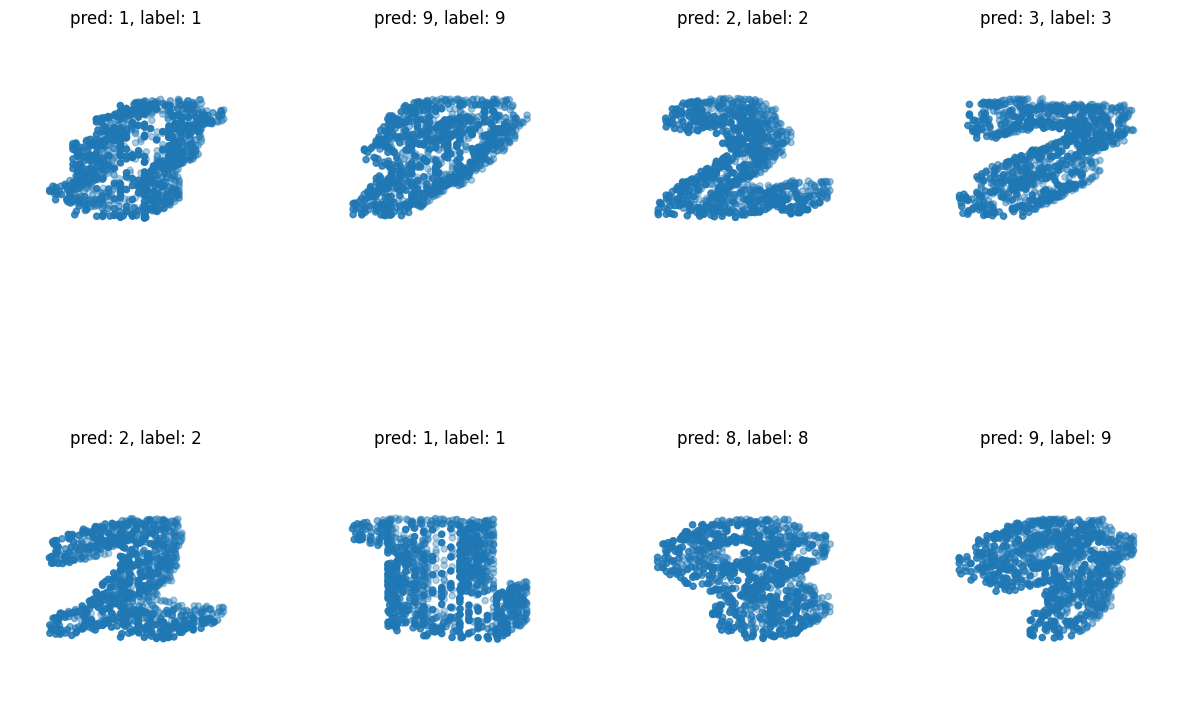

In [26]:
data = test_dataset_3d.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            preds[i].numpy(), labels.numpy()[i]
        )
    )
    ax.set_axis_off()
    ax.view_init(5, 15)
plt.show()


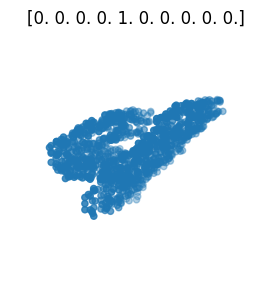

In [47]:
image = x_test_3d_sel[0]
label = y_test_sel_b[0]



# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 4, i + 1, projection="3d")
ax.scatter(image[:, 0], image[:, 1], image[:, 2])
ax.set_axis_off()
ax.view_init(5, 15)
plt.title(label)
plt.show()

# image = tf.Tensor(image, dtype = float)
# label = tf.Tensor(label, dtype = float)

In [51]:
image = x_test_3d_sel[0:1]
label = y_test_sel_b[0:1]

image = tf.convert_to_tensor(image)
label = tf.convert_to_tensor(label)



In [52]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
perturbations = create_adversarial_pattern(image, label)


1/1 [==============================] - 0s 27ms/step


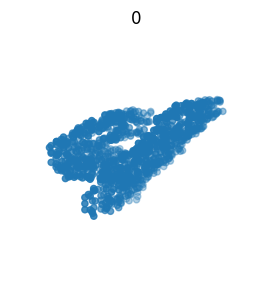

4 0.9942048
1/1 [==============================] - 0s 20ms/step


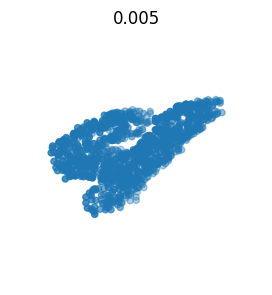

4 0.95468575
1/1 [==============================] - 0s 21ms/step


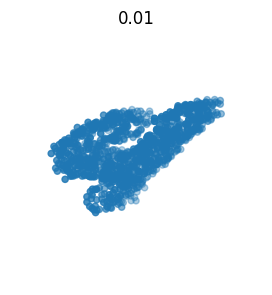

4 0.7272233
1/1 [==============================] - 0s 23ms/step


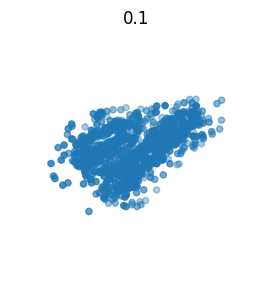

9 0.3243795


In [68]:
epsilons = [0, 0.005, 0.01, 0.1]

for eps in epsilons:

    del_x = perturbations.numpy() * eps

    adv_image = image + del_x


    # Predict and plot
    adv_pred = model.predict(adv_image)

    # plot points with predicted class and label
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(adv_image[0, :, 0], adv_image[0, :, 1], adv_image[0, :, 2])
    ax.set_axis_off()
    ax.view_init(5, 15)
    plt.title(eps)
    plt.show()
    
    print(np.argmax(adv_pred), np.max(adv_pred))

    

4 0.9942048


(9, 0.3943533)

In [ ]:
# # Get the input label of the image.
# labrador_retriever_index = 208
# label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
# label = tf.reshape(label, (1, image_probs.shape[-1]))

# points, 

plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

# Going with 2D Mnist dataset...

In [ ]:
# Build the model

num_classes = 10
input_shape = (30, 30, 1)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

In [ ]:
# Train the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["sparse_categorical_accuracy"])
model.fit(train_dataset_2d, epochs = 1000, validation_data=test_dataset_2d)

In [ ]:
#Save model...
model.save('models/mnist2d')

# Evaluate the trained model
model = keras.models.load_model('models/mnist2d')

In [ ]:
# score = model.evaluate(x_test_2d_sel, y_test_sel, verbose=0)
# print("Test loss:", score[0])
# print("Test accuracy:", score[1])

In [ ]:
data = test_dataset_2d.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):

    print(f"pred: {preds[i].numpy()}, label: {labels.numpy()[i]}") #.format(preds[i].numpy(), labels.numpy()[i])

    ax = fig.add_subplot(2, 4, i + 1)

    ax.imshow(points[i, :, :, 0])
    
    ax.set_title(
        "pred: {:}, label: {:}".format(
            preds[i].numpy(), labels.numpy()[i]
        )
    )
    ax.set_axis_off()
plt.show()


In [ ]:
# Creating model and training as 10D array...
num_classes = 10
input_shape = (30, 30, 1)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

In [ ]:
# Train the model

batch_size = 128
epochs = 50

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train_2d_sel, y_train_sel_b, batch_size=batch_size, epochs=epochs, validation_split=0.1)


In [ ]:
points, labels = x_test_2d_sel[-8:], y_test_sel_b[-8:]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)
labels = np.argmax(labels, axis = 1)


# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):

    print(f"pred: {preds[i].numpy()}, label: {labels[i]}") #.format(preds[i].numpy(), labels.numpy()[i])

    ax = fig.add_subplot(2, 4, i + 1)

    ax.imshow(points[i, :, :, 0])
    
    ax.set_title(
        "pred: {:}, label: {:}".format(
            preds[i].numpy(), labels[i]
        )
    )
    ax.set_axis_off()
plt.show()


In [ ]:
import seaborn as sns
sns.heatmap(pd.DataFrame(x_train_2d[0,:, :, 0]))

In [ ]:
# Train the model

batch_size = 128
epochs = 5

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["sparse_categorical_accuracy"])


# model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
model.fit(train_dataset_2d, epochs = 5, validation_data=test_dataset_2d)

In [ ]:
# Set up
import numpy as np
from tensorflow import keras
from keras import layers

In [ ]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
# # your code

In [ ]:
# Prepare the data

num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train_sel, num_classes)
y_test = keras.utils.to_categorical(y_test_sel, num_classes)

In [ ]:
import seaborn as sns
sns.heatmap(pd.DataFrame(x_train[0,:, :, 0]))

In [ ]:
y_test

In [ ]:
x_train_2d = x_train_2d.reshape(-1, 30, 30, 1)
x_test_2d = x_test_2d.reshape(-1, 30, 30, 1)


In [ ]:
# Prepare the data

num_classes = 10
input_shape = (30, 30, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Build the model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

In [ ]:
# Train the model

batch_size = 128
epochs = 5

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["sparse_categorical_accuracy"])


# model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
model.fit(train_dataset_2d, epochs = 5, validation_data=test_dataset_2d)


In [ ]:
#Save model...
model.save('models/mnist2d')

In [ ]:
# Evaluate the trained model
model = keras.models.load_model('models/mnist2d')

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])